In [1]:
!pip install torchsummary
!pip install --upgrade wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.2 MB/s eta 0:00:00


In [2]:
import torch
import torchvision

print("PyTorch Version:", torch.__version__)
print("torchvision Version:", torchvision.__version__)
if torch.cuda.is_available():
  print(torch.cuda.current_device())

PyTorch Version: 2.1.0+cu118
torchvision Version: 0.16.0+cu118
0


In [3]:
!nvidia-smi

Sat Dec  9 00:59:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [5]:
# model.py
import numpy as np
import torch.nn as nn
import torchvision.models as models
from torchsummary import summary

class DeconvMobileNet(nn.Module):
    def __init__(self, num_classes, init_weights):
        super(DeconvMobileNet, self).__init__()

        # Use the specified weights argument
        mobilenet = models.mobilenet_v3_small(weights='IMAGENET1K_V1')
        features = list(mobilenet.features.children())
        classifier = list(mobilenet.classifier.children())

        # Extracting layers from MobileNetV3
        self.conv1 = nn.Sequential(features[0])
        self.pool1 = nn.MaxPool2d(kernel_size=1, stride=1, padding=0, return_indices=True)# stride 1 instead of 2

        self.conv2 = nn.Sequential(features[1], features[2], features[3])
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=1, padding=0, return_indices=True)# stride 1 instead of 2

        self.conv3 = nn.Sequential(features[4], features[5], features[6])
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=1, padding=0, return_indices=True)# stride 1 instead of 2

        self.conv4 = nn.Sequential(features[7], features[8], features[9])
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=1, padding=0, return_indices=True) # stride 1 instead of 2

        self.conv5 = nn.Sequential(features[10], features[11], features[12])
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=1, padding=0, return_indices=True) # stride 1 instead of 2

        # Conv67 layer
        self.conv67 = nn.Sequential(
            nn.Conv2d(576, 1024, kernel_size=(1, 1)),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 1000, kernel_size=(1, 1)),
            nn.BatchNorm2d(1000),
            nn.ReLU()
        )

        # Load weights for conv6 and conv7
        w_conv6 = classifier[0].state_dict()
        w_conv7 = classifier[3].state_dict()

        new_input_channels_conv6 = 96
        w_conv6_adjusted = w_conv6['weight'].unsqueeze(2).unsqueeze(3)  # .view(1024, 576, 1, 1)
        self.conv67[0].weight.data.copy_(w_conv6_adjusted)
        self.conv67[0].bias.data.copy_(w_conv6['bias'])
        self.conv67[3].weight.data.copy_(w_conv7['weight'].view(1000, 1024, 1, 1))
        self.conv67[3].bias.data.copy_(w_conv7['bias'])

        # Define deconvolution layers
        self.deconv67 = nn.Sequential(
            nn.ConvTranspose2d(1000, 1024, kernel_size=1, stride=1, padding=0),  # Mirrors conv67
            nn.BatchNorm2d(1024),
            nn.ReLU()
        )

        self.unpool5 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.deconv5 = nn.Sequential(
            nn.ConvTranspose2d(1024, 576, kernel_size=3, stride=1, padding=1),  # Mirrors conv5
            nn.BatchNorm2d(576),
            nn.ReLU(),
            nn.ConvTranspose2d(576, 576, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(576),
            nn.ReLU(),
            nn.ConvTranspose2d(576, 96, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(96),
            nn.ReLU()
        )

        self.unpool4 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.deconv4 = nn.Sequential(
            nn.ConvTranspose2d(96, 96, kernel_size=3, stride=1, padding=1),  # Mirrors conv4
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.ConvTranspose2d(96, 96, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.ConvTranspose2d(96, 40, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(40),
            nn.ReLU()
        )

        self.unpool3 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.deconv3 = nn.Sequential(
            nn.ConvTranspose2d(40, 40, kernel_size=3, stride=1, padding=1),  # Mirrors conv3
            nn.BatchNorm2d(40),
            nn.ReLU(),
            nn.ConvTranspose2d(40, 40, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(40),
            nn.ReLU(),
            nn.ConvTranspose2d(40, 24, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(24),
            nn.ReLU()
        )

        self.unpool2 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(24, 24, kernel_size=3, stride=1, padding=1),  # Mirrors conv2
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.ConvTranspose2d(24, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )

        self.unpool1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(16, 16, kernel_size=3, stride=1, padding=1),  # Mirrors conv1
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, num_classes, kernel_size=1, stride=1, padding=0)
        )

        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        original = x

        x = self.conv1(x)
        # x, p1 = self.pool1(x)

        x = self.conv2(x)
        # x, p2 = self.pool2(x)

        x = self.conv3(x)
        # x, p3 = self.pool3(x)

        x = self.conv4(x)
        # x, p4 = self.pool4(x)

        x = self.conv5(x)
        # x, p5 = self.pool5(x)

        x = self.conv67(x)
        x = self.deconv67(x)

        # x = self.unpool5(x)
        x_interp = torch.nn.functional.interpolate(x, scale_factor=2, mode='nearest')
        x = self.deconv5(x_interp)

        # x = self.unpool4(x, p4)
        x_interp = torch.nn.functional.interpolate(x, scale_factor=2, mode='nearest')
        x = self.deconv4(x_interp)

        # x = self.unpool3(x, p3)
        x_interp = torch.nn.functional.interpolate(x, scale_factor=2, mode='nearest')
        x = self.deconv3(x_interp)

        # x = self.unpool2(x, p2)
        x_interp = torch.nn.functional.interpolate(x, scale_factor=2, mode='nearest')
        x = self.deconv2(x_interp)

        # x = self.unpool1(x, p1)
        x_interp = torch.nn.functional.interpolate(x, scale_factor=2, mode='nearest')
        x = self.deconv1(x_interp)

        return x

    def _initialize_weights(self):
        targets = [self.conv67, self.deconv67, self.deconv5, self.deconv4, self.deconv3, self.deconv2, self.deconv1]
        for layer in targets:
            for module in layer.children():
                if isinstance(module, nn.BatchNorm2d):
                    nn.init.constant_(module.weight, 1)
                    nn.init.constant_(module.bias, 0)
                elif isinstance(module, nn.ConvTranspose2d):
                    nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
                    if module.bias is not None:
                        nn.init.constant_(module.bias, 0)


if __name__ == '__main__':
    # Instantiate the model
    num_classes = 21 # 20 classes + background
    test_model = DeconvMobileNet(num_classes=num_classes, init_weights=True).to('cuda')

    # Print model summary
    input_shape = (3, 224, 224)  # Adjust the input shape accordingly
    summary(test_model, input_size=input_shape, device='cuda')

    # Generate random input data (batch size = 1, channels = 3, height = 224, width = 224)
    input_shape = (1, 3, 224, 224)
    input_data = torch.randn(input_shape).to('cuda')

    # Forward pass
    wanted_output_shape = (1, num_classes, 224, 224)
    output = test_model(input_data)

    # Print the output shape
    assert output.size() == wanted_output_shape, f"Current output Shape is {output.size()} and should be {wanted_output_shape}"

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 52.5MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4           [-1, 16, 56, 56]             144
       BatchNorm2d-5           [-1, 16, 56, 56]              32
              ReLU-6           [-1, 16, 56, 56]               0
 AdaptiveAvgPool2d-7             [-1, 16, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             136
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]             144
      Hardsigmoid-11             [-1, 16, 1, 1]               0
SqueezeExcitation-12           [-1, 16, 56, 56]               0
           Conv2d-13           [-1, 16, 56, 56]             256
      BatchNorm2d-14           [-1, 16,

In [6]:
# pipeline.py
from google.colab import drive
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, RandomSampler
from torchvision.transforms import v2
from torchvision.datasets import VOCSegmentation
import matplotlib.pyplot as plt
import numpy as np
import random
import logging
import os
import wandb

In [157]:
import torchvision.transforms.v2.functional as F
from PIL import Image

import math
import numbers
from collections.abc import Sequence

VOC_CLASSES = np.array([
    "background", "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car",
    "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person",
    "potted plant", "sheep", "sofa", "train", "tv/monitor",
])

VOC_COLORMAP = np.array([
    [0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128], [128, 0, 128],
    [0, 128, 128], [128, 128, 128], [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
    [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128], [0, 64, 0], [128, 64, 0],
    [0, 192, 0], [128, 192, 0], [0, 64, 128],
])

class Mask_Aug():
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, mask):
        for t in self.transforms:
            image, mask = t(image, mask)
        return image, mask

class ToTensor:
    """
    Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].
    Only applied to image not mask.
    """
    def __call__(self, image, mask):
        return F.to_tensor(image), mask

class PILToTensor:
    """
    Converts a PIL Image (H x W x C) to a Tensor of shape (C x H x W).
    Only applied to mask not image.
    """
    def __call__(self, image, mask):
        mask = F.pil_to_tensor(mask)
        # Remove border
        mask[mask == 255] = 0
        return image, mask

class ToPILImage:
    """
    Converts a torch.*Tensor of shape C x H x W or a numpy ndarray of shape H x W x C to a PIL Image while preserving the value range.
    """

    def __init__(self, mode=None):
        self.mode = mode

    def __call__(self, image, mask):
        colored_mask = VOC_COLORMAP[mask.cpu()].squeeze(0).astype('uint8')
        return F.to_pil_image(image, self.mode), F.to_pil_image(colored_mask, self.mode)

class ToDtype:
    def __init__(self, dtype, scale=False):
        self.dtype = dtype
        self.scale = scale

    def __call__(self, image, target):
        if not self.scale:
            return image.to(dtype=self.dtype), target
        image = F.convert_image_dtype(image, self.dtype)
        return image, target

class Normalize:
    """
    Normalize a tensor image with mean and standard deviation.
    Only applied to image not mask.
    """
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, image, target):
        image = F.normalize(image, mean=self.mean, std=self.std)
        return image, target

class Resize(torch.nn.Module):
    """
    Resize the input image to the given size.
    """

    def __init__(self, size, image_interpolation=Image.BILINEAR, mask_interpolation=Image.NEAREST, antialias=True):
        super().__init__()
        if not isinstance(size, (int, Sequence)):
            raise TypeError(
                'Size should be int or sequence. Got {}'.format(type(size)))
        if isinstance(size, Sequence) and len(size) not in (1, 2):
            raise ValueError(
                'If size is a sequence, it should have 1 or 2 values')
        self.size = size
        self.image_interpolation = image_interpolation
        self.mask_interpolation = mask_interpolation
        self.antialias = antialias

    def forward(self, image, mask):
        return F.resize(image, self.size, self.image_interpolation, antialias=self.antialias), F.resize(mask, self.size, self.mask_interpolation, antialias=self.antialias)

class RandomCrop(torch.nn.Module):
    """
    Crop the given image at a random location.
    """
    @staticmethod
    def get_params(image, output_size):
        h, w = F.get_size(image)
        th, tw = output_size

        if (h+1 < th) or (w+1 < tw):
            raise ValueError(
                'Required crop size {} is larger then input image size {}'.format((th, tw), (h, w)))

        if w == tw and h == th:
            return 0, 0, h, w

        i = torch.randint(0, h - th + 1, size=(1, )).item()
        j = torch.randint(0, w - tw + 1, size=(1, )).item()
        return i, j, th, tw

    def __init__(self, size, padding=None, pad_if_needed=False, fill=0, padding_mode='constant'):
        super().__init__()
        self.size = tuple(_setup_size(
            size, error_msg='Please provide only two dimensions (h, w) for size.'))
        self.padding = padding
        self.pad_if_needed = pad_if_needed
        self.fill = fill
        self.padding_mode = padding_mode

    def forward(self, image, mask):
        if self.padding is not None:
            image = F.pad(image, self.padding, self.fill, self.padding_mode)
            mask = F.pad(mask, self.padding, self.fill, self.padding_mode)

        height, width = F.get_size(image)

        # pad if needed
        if self.pad_if_needed and (width < self.size[1]):
            padding = [self.size[1] - width, 0]
            image = F.pad(image, padding, self.fill, self.padding_mode)
            mask = F.pad(mask, padding, self.fill, self.padding_mode)

        if self.pad_if_needed and (height < self.size[0]):
            padding = [0, self.size[0] - height]
            image = F.pad(image, padding, self.fill, self.padding_mode)
            mask = F.pad(mask, padding, self.fill, self.padding_mode)

        i, j, h, w = self.get_params(image, self.size)

        return F.crop(image, i, j, h, w), F.crop(mask, i, j, h, w)

class RandomHorizontalFlip:
    def __init__(self, flip_prob):
        self.flip_prob = flip_prob

    def __call__(self, image, target):
        if random.random() < self.flip_prob:
            image = F.hflip(image)
            target = F.hflip(target)
        return image, target

def _setup_size(size, error_msg):
    if isinstance(size, numbers.Number):
        return int(size), int(size)

    if isinstance(size, Sequence) and len(size) == 1:
        return size[0], size[0]

    if len(size) != 2:
        raise ValueError(error_msg)

    return size

In [153]:
class SemanticSegmentationDataset:
    def __init__(self, root, year, image_set, batch_size=64, shuffle=True, transforms=None):
        self.batch_size = batch_size
        self.transforms = transforms

        self.dataset = VOCSegmentation(root=root, # Root directory of the VOC Dataset
                                       year=year, # The dataset year, supports years "2007" to "2012".
                                       image_set=image_set, # Select the image_set to use
                                       download=True, # If true, downloads the dataset from the internet and puts it in root directory.
                                       transforms=self.transforms)

        self.loader = DataLoader(self.dataset,
                                 batch_size=self.batch_size,
                                 shuffle=shuffle,
                                 pin_memory=True) # Move to GPU

        # Asserts
        input_shape = (self.batch_size, 3, 224, 224)
        target_shape = (self.batch_size, 1, 224, 224)
        images, targets = next(iter(self.loader))

        assert images.size() == input_shape, f"Wrong input shape, found {images.size()}, expected {input_shape}"
        assert targets.size() == target_shape, f"Wrong target shape, found {targets.size()}, expected {target_shape}"

        mask=targets[1][0]
        mask_np = mask.numpy()
        unique_values = np.unique(mask_np)

        assert all(0 <= value < num_classes for value in unique_values), "Values are not within the specified range."

    def plot(self, model):
        images, targets = next(iter(self.loader))
        images, targets = images.cuda(gpu_id, non_blocking=True), targets.cuda(gpu_id, non_blocking=True)
        prediction = model(images)

        for idx in range(3):
            # Display the image, ground truth, and prediction
            plt.figure(figsize=(15, 5))

            input_image, ground_truth = ToPILImage()(images[idx], targets[idx])
            predicted_mask = prediction[idx].argmax(dim=0).unsqueeze(0).byte()
            c, h, w = predicted_mask.shape
            _, predicted_mask = ToPILImage()(images[idx], predicted_mask)

            # Input Image
            plt.subplot(1, 3, 1)
            plt.imshow(input_image)
            plt.title('Input Image')
            plt.axis('off')

            # Ground Truth
            plt.subplot(1, 3, 2)
            plt.imshow(ground_truth)
            plt.title('Ground Truth')
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            plt.imshow(predicted_mask)
            plt.title('Prediction')
            plt.axis('off')

            plt.show()

In [168]:
class SemanticSegmentationTrainer:
    def __init__(self, model, train_dataset, val_dataset, criterion, optimizer, num_epochs=10, patience=5, gpu_id=0):
        self.model = model
        self.model_is_best = False
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.criterion = criterion
        self.optimizer = optimizer
        self.num_epochs = num_epochs
        self.patience = patience
        self.early_stopping_counter = 0
        self.best_val_loss = float('inf')

        self.gpu=gpu_id
        torch.cuda.set_device(self.gpu)

    def save_model_and_optimizer(self, epoch, train_loss, val_loss):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'training_loss': train_loss,
            'val_loss': val_loss
        }
        # Create the directory if it doesn't exist
        model_directory = drive_path + '/checkpoint/'
        os.makedirs(model_directory, exist_ok=True)

        model_path = model_directory + f"/checkpoint_{epoch}.pth"
        torch.save(checkpoint, model_path)

        # ... Create a Model Version
        art = wandb.Artifact(f"mobileNet-ss-{wandb.run.id}", type="model")
        # ... Add the serialized files
        art.add_file(model_path, "model.pth")
        # (optional) Log training metrics
        wandb.log({"train_loss": train_loss, "val_loss": val_loss})
        # ... Log the Version
        if self.model_is_best:
            # If the model is the best model so far,
            #  add "best" to the aliases
            wandb.log_artifact(art, aliases=["latest", "best"])
        else:
            wandb.log_artifact(art)

        print(f'Model and optimizer saved at epoch {epoch} with validation loss {val_loss}.')

    def load_model_and_optimizer(self, model, optimizer, path="checkpoint_{idx_epoch}.pth"):
        checkpoint = torch.load(path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        training_loss = checkpoint['training_loss']
        val_loss = checkpoint['val_loss']

        print(f'Model and optimizer saved at epoch {epoch} with validation loss {val_loss}.')

        return model, optimizer

    def early_stopping(self, val_loss):
        if val_loss < self.best_val_loss:
            self.model_is_best = True
            self.best_val_loss = val_loss
            self.early_stopping_counter = 0
        else:
            self.model_is_best = False
            self.early_stopping_counter += 1

        return self.early_stopping_counter >= self.patience

    def train(self):
        for epoch in range(self.num_epochs):
            self.model.train()
            total_loss = 0

            for images, targets in self.train_dataset.loader:
                batch, channel, height, width = targets.shape
                # the target tensor should have the shape (batch_size, height, width)
                targets = targets.view(batch, height, width).type(torch.LongTensor)

                # Move the tensors to the GPU, place of this line important
                # target.view seem to change the device
                images, targets = images.cuda(self.gpu, non_blocking=True), targets.cuda(self.gpu, non_blocking=True)

                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, targets)
                loss.backward()
                self.optimizer.step()

                total_loss += loss.item()

            avg_training_loss = total_loss / self.train_dataset.batch_size

            # Validation
            self.model.eval()
            total_val_loss = 0

            with torch.no_grad():
                for val_images, val_targets in self.val_dataset.loader:
                    batch, channels, height, width = val_targets.shape
                    # the target tensor should have the shape (batch_size, height, width)
                    val_targets = val_targets.view(batch, height, width).type(torch.LongTensor)

                    # Move the tensors to the GPU, place of this line important
                    # val_targets.view seem to change the device
                    val_images, val_targets = val_images.cuda(self.gpu, non_blocking=True), val_targets.cuda(self.gpu, non_blocking=True)

                    val_outputs = self.model(val_images)
                    val_loss = self.criterion(val_outputs, val_targets)
                    total_val_loss += val_loss.item()

            avg_val_loss = total_val_loss / self.val_dataset.batch_size

            print(f"Epoch: {epoch}, train_loss: {avg_training_loss}, val_loss: {avg_val_loss}")
            wandb.log({"epoch": epoch, "train_loss": avg_training_loss, "val_loss": avg_val_loss})

            # Early stopping check
            if self.early_stopping(avg_val_loss):
                print(f'Early stopping at epoch {epoch} due to no improvement in validation loss.')
                break

            # Save checkpoint
            self.save_model_and_optimizer(epoch,
                                          avg_training_loss,
                                          avg_val_loss)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
train_loss,██▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
val_loss,████▅▅▅▅▃▃▄▄▄▄▃▃▂▂▃▃▂▂▁▁▃▃▁▁▂▂▂▂▁
epoch,16
train_loss,5.74694
val_loss,57.69553


Using downloaded and verified file: /content/gdrive/My Drive/semantic_segmentation/data/VOCtrainval_11-May-2012.tar
Extracting /content/gdrive/My Drive/semantic_segmentation/data/VOCtrainval_11-May-2012.tar to /content/gdrive/My Drive/semantic_segmentation/data/
Using downloaded and verified file: /content/gdrive/My Drive/semantic_segmentation/data/VOCtrainval_11-May-2012.tar
Extracting /content/gdrive/My Drive/semantic_segmentation/data/VOCtrainval_11-May-2012.tar to /content/gdrive/My Drive/semantic_segmentation/data/
Epoch: 0, train_loss: 15.27280905842781, val_loss: 88.90703915804625
Model and optimizer saved at epoch 0 with validation loss 88.90703915804625.
Epoch: 1, train_loss: 11.092158551017443, val_loss: 85.81987047195435
Model and optimizer saved at epoch 1 with validation loss 85.81987047195435.
Epoch: 2, train_loss: 10.417873015006384, val_loss: 79.66747833788395
Model and optimizer saved at epoch 2 with validation loss 79.66747833788395.
Epoch: 3, train_loss: 9.8428009450

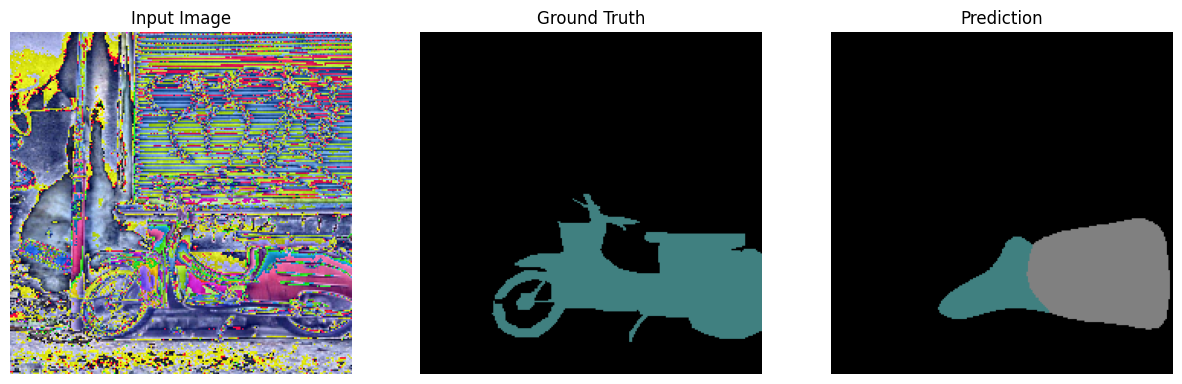

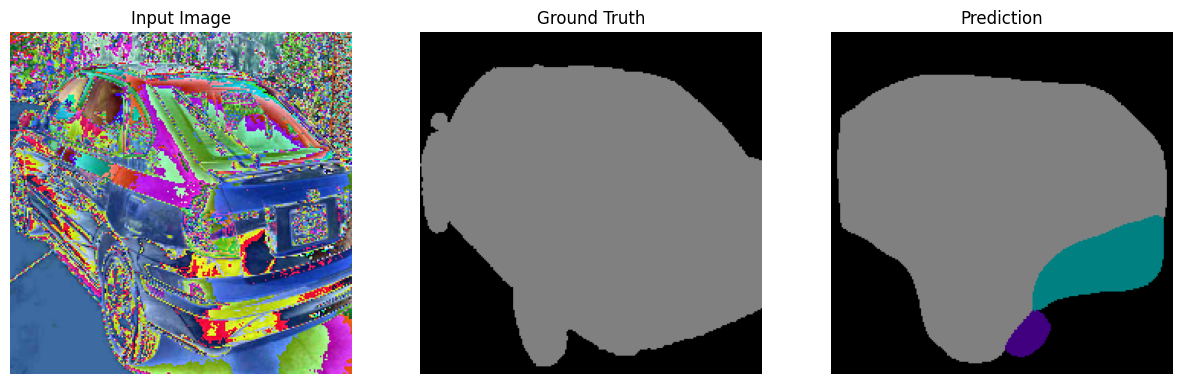

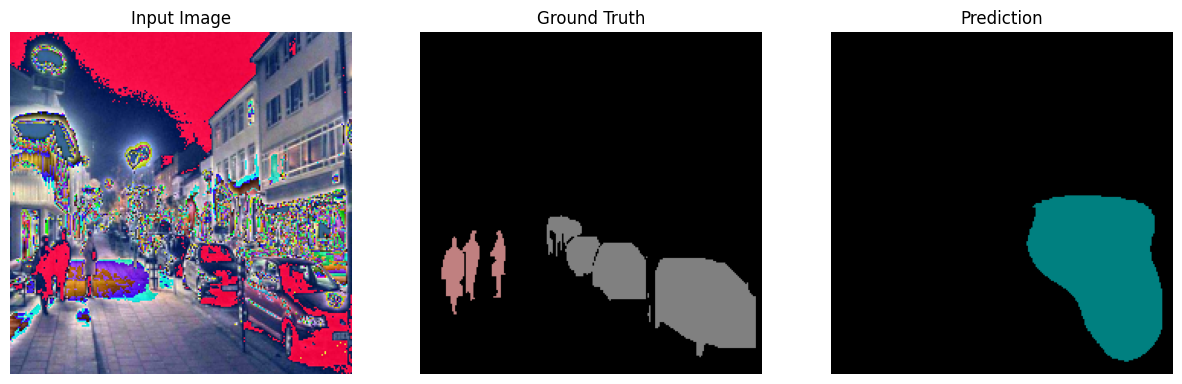

epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
train_loss,██▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_loss,██▇▇▆▆▅▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▃▃▃▂▂▂▁▁▁▁▁▃▃▃▃▁▃
epoch,23
train_loss,5.32215
val_loss,64.0665


In [169]:
import os

class SemanticSegmentationPipeline:
    def __init__(self, num_classes, train_batch_size, val_batch_size, num_epochs, root='./data', year='2012', gpu_id=0):
        self.root = root
        self.year = year
        self.num_classes = num_classes
        self.train_batch_size = train_batch_size
        self.val_batch_size = val_batch_size
        self.num_epochs = num_epochs

        self.gpu=gpu_id
        torch.cuda.set_device(self.gpu)

    def run(self):
        wandb.init(
            # Set the project where this run will be logged
            project="semantic-segmentation",
            # Track hyperparameters and run metadata
            config={
                "num_classes": num_classes,
                "num_epochs": num_epochs,
                "learning_rate": lr,
                "momentum": momentum,
                "weight_decay": weight_decay,
                "train_batch_size": train_batch_size,
                "val_batch_size": val_batch_size,
            },
        )

        train_tf = Mask_Aug(transforms=[
                                            ToTensor(),
                                            PILToTensor(),
                                            Resize((256, 256)), RandomCrop((224, 224)),
                                            RandomHorizontalFlip(0.5),
                                            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                        ])

        val_tf = Mask_Aug(transforms=[
                                          ToTensor(),
                                          PILToTensor(),
                                          Resize((224, 224)),
                                          Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                      ])

        train_dataset = SemanticSegmentationDataset(root=self.root,
                                                    year=self.year,
                                                    image_set='train',
                                                    batch_size=self.train_batch_size,
                                                    shuffle=True,
                                                    transforms=train_tf)

        val_dataset = SemanticSegmentationDataset(root=self.root,
                                                  year=self.year,
                                                  image_set='val',
                                                  batch_size=self.val_batch_size,
                                                  shuffle=False,
                                                  transforms=val_tf)

        model = DeconvMobileNet(num_classes=self.num_classes,
                                init_weights=True).cuda(self.gpu)

        # To validate transform
        # train_dataset.plot(model)

        # cf. https://github.com/Jasonlee1995/DeconvNet
        criterion = nn.CrossEntropyLoss().cuda(self.gpu)
        optimizer = optim.SGD(model.parameters(),
                              lr=lr,
                              momentum=momentum,
                              weight_decay=weight_decay)

        trainer = SemanticSegmentationTrainer(model,
                                              train_dataset,
                                              val_dataset,
                                              criterion,
                                              optimizer,
                                              self.num_epochs)

        trainer.train()
        # To follow training progress
        train_dataset.plot(model)

if __name__ == "__main__":
    # Mount Google Drive
    drive.mount('/content/gdrive')
    # Provide the path to Google Drive directory
    drive_path = '/content/gdrive/My Drive/semantic_segmentation/'

    gpu_id=0

    num_classes = 21 # 20 classes + background

    num_epochs = 50

    lr = 0.01
    momentum = 0.9
    weight_decay = 0.0005

    train_batch_size = 12
    val_batch_size = 4

    os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

    wandb.login()
    pipeline = SemanticSegmentationPipeline(num_classes, train_batch_size, val_batch_size, num_epochs,
                                            root=drive_path+'data/', gpu_id=gpu_id)
    pipeline.run()
    wandb.finish()

# Test transform

In [148]:
train_tf = Mask_Aug(transforms=[            ToTensor(),
                                            PILToTensor(),
                                            Resize((256,256)), RandomCrop((224, 224)),
                                            RandomHorizontalFlip(0.5),
                                            ToDtype(dtype=torch.float32),
                                            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                        ])

val_tf = Mask_Aug(transforms=[
                                  ToTensor(),
                                  PILToTensor(),
                                  Resize((224, 224)),
                                  Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                            ])

train_dataset = SemanticSegmentationDataset(root='/content/gdrive/My Drive/semantic_segmentation/data/',
                                            year='2012',
                                            image_set='train',
                                            batch_size=12,
                                            shuffle=True,
                                            transforms=train_tf)

"""
val_dataset = SemanticSegmentationDataset(root='/content/gdrive/My Drive/semantic_segmentation/data/',
                                          year='2012',
                                          image_set='val',
                                          batch_size=4,
                                          shuffle=False,
                                          transforms=val_tf)
"""

Using downloaded and verified file: /content/gdrive/My Drive/semantic_segmentation/data/VOCtrainval_11-May-2012.tar
Extracting /content/gdrive/My Drive/semantic_segmentation/data/VOCtrainval_11-May-2012.tar to /content/gdrive/My Drive/semantic_segmentation/data/


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(


"\nval_dataset = SemanticSegmentationDataset(root='/content/gdrive/My Drive/semantic_segmentation/data/',\n                                          year='2012',\n                                          image_set='val',\n                                          batch_size=4,\n                                          shuffle=False,\n                                          transforms=val_tf)\n"

In [149]:
test = next(iter(train_dataset.loader))
image=test[0][10]
target=test[1][10]
print(image.shape)
print(target.shape)

torch.Size([3, 224, 224])
torch.Size([1, 224, 224])


In [150]:
tensor_np = target.numpy()
# Get unique values from the tensor
unique_values = np.unique(tensor_np)
print(unique_values)

[0 4]


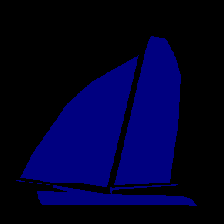

In [151]:
a,b=ToPILImage()(image,target)
b

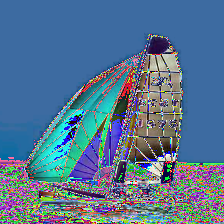

In [152]:
a

In [ ]:
DeconvMobileNet(num_classes=21, init_weights=True).cuda(0)

RuntimeError: ignored